# Clustering of pharmacy clients

**Objective:**

1. Conduct clustering of pharmacy clients according to available data; Describe and analyze the resulting clusters; to give recommendations for further work with each cluster.

2. Based on available data, build a predictive model that will determine in the future by the same activities to which the client will potentially get into the cluster.

**Description of features:**

* keyCustomer - unique client key
* Age - age
* FirstOrderDate - date of first order
* SalesSumTotal - the total amount of all orders for the entire period that is considered
* SKUQty - the number of SKU (unique product items) for the period, that is, the variety of customer choices
* AvgOrder - average check
* FarmsQty - the number of pharmacies in which the customer made purchases
* LastOrderDate - date of the last order
* OrderCount - the number of orders (checks)
* OrderFrq - frequency of purchases. Do not focus on this field yet; it is not descriptive
* DaysFromLastOrder - number of days from the last purchase
* WeeksFromLastOrder - the number of weeks since the last purchase
* ATC4Qty, ATC3Qty, ATC2Qty, ATC1Qty - parameters that describe drugs
* DaysFromFirstOrder - number of days after the first purchase
* WeeksFromFirstOrder - the number of weeks after the first purchase
* StDevDates - a parameter that characterizes the density of purchases
* VisitCount - number of visits

In [73]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import catboost

import xgboost

import lightgbm

# Data loading

In [2]:
# read the data
data = pd.read_csv('data.csv')
drug_clients = data.copy()

In [3]:
# dates, index and numerical features - all that not for clustering
drug_clients.drop(['FirstOrderDate', 'keyCustomer', 'FarmsQty', 'LastOrderDate', 'OrderFrqPct', 'DaysFromLastOrder', \
                   'WeeksFromLastOrder', 'DaysFromFirstOrder', 'WeeksFromFirstOrder'], axis=1, inplace=True)

# Data clearinig

### Check the problems with NaN (-1) values for Age feature


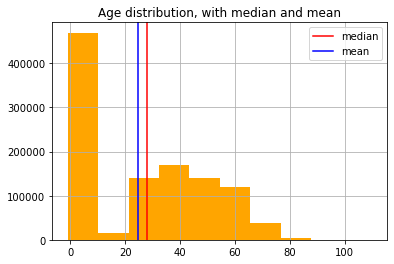

'We need to re-fill age values with same distribution as existing values '

In [4]:
drug_clients.Age.hist(bins=10, color='orange')
plt.title('Age distribution, with median and mean')
plt.axvline(drug_clients.Age.median(), c='r', label='median')
plt.axvline(drug_clients.Age.mean(), c='b', label='mean')
plt.legend()
plt.show();

'''We need to re-fill age values with same distribution as existing values '''

In [5]:
'''Function to fill Age -1 values with same disrtibution of the age'''

std = data.Age.std()
mean = data.Age.mean()

def lof(x):
    result = 0
    if x == -1:
        while result < 18:
            result = np.random.normal(mean, std)
        return result
    else:
        return x
    
# Filling
drug_clients.Age = drug_clients.Age.apply(lambda x: int(lof(x)))

In [6]:
# checking
assert len(drug_clients[drug_clients.Age == -1]) == 0

### Replace -1 values (not defined) with same distribution  


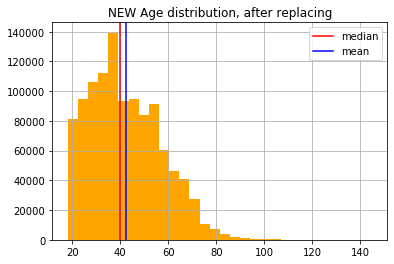

In [7]:
# draw
drug_clients.Age.hist(bins=30, color='orange')
plt.title('NEW Age distribution, after replacing')
plt.axvline(drug_clients.Age.median(), c='r', label='median')
plt.axvline(drug_clients.Age.mean(), c='b', label='mean')
plt.legend()
plt.show();

In [8]:
# check age less than 18
assert len(drug_clients[drug_clients.Age < 18]) == 0

## Replace str values StDevDates

In [9]:
# replace '-'
drug_clients.StDevDates.replace('-', 0, inplace=True)
# convert to float
drug_clients.StDevDates = drug_clients.StDevDates.astype(float)

In [10]:
# check consistence
drug_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099291 entries, 0 to 1099290
Data columns (total 11 columns):
Age              1099291 non-null int64
SalesSumTotal    1099291 non-null float64
SKUQty           1099291 non-null float64
AvgOrder         1099291 non-null float64
OrderCount       1099291 non-null int64
ATC4Qty          1099291 non-null int64
ATC3Qty          1099291 non-null int64
ATC2Qty          1099291 non-null int64
ATC1Qty          1099291 non-null int64
StDevDates       1099291 non-null float64
VisitCount       1099291 non-null int64
dtypes: float64(4), int64(7)
memory usage: 92.3 MB


# Some general stat data

In [11]:
display(drug_clients.describe())
drug_clients_clean = drug_clients.copy()
display(f'Unique numbers of SKU is {len(drug_clients_clean.SKUQty.unique())} items')

,Age,SalesSumTotal,SKUQty,AvgOrder,OrderCount,ATC4Qty,ATC3Qty,ATC2Qty,ATC1Qty,StDevDates,VisitCount
count,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06,1.099291e+06
mean,4.213542e+01,1.715854e+03,1.460814e+01,2.430360e+02,8.871006e+00,8.926860e+00,8.122736e+00,7.355577e+00,4.564413e+00,4.044929e+01,6.851895e+00
std,1.496115e+01,1.203228e+04,4.514148e+01,2.583832e+02,8.254254e+01,1.253113e+01,9.901311e+00,7.825989e+00,3.339626e+00,4.448812e+01,1.091657e+01
min,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.000000e+01,2.527000e+02,2.000000e+00,1.087600e+02,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00
50%,4.000000e+01,6.230000e+02,6.000000e+00,1.770800e+02,3.000000e+00,5.000000e+00,5.000000e+00,4.000000e+00,4.000000e+00,2.463000e+01,3.000000e+00
75%,5.300000e+01,1.669500e+03,1.600000e+01,2.870050e+02,9.000000e+00,1.200000e+01,1.100000e+01,1.000000e+01,7.000000e+00,7.666000e+01,8.000000e+00
max,1.450000e+02,3.280129e+06,6.058000e+03,3.859038e+04,2.545500e+04,3.990000e+02,1.940000e+02,8.900000e+01,1.500000e+01,2.573900e+02,3.630000e+02


'Unique numbers of SKU is 1084 items'

* Average check is 177 gr
* Average age is 40 (after tranformation)
* In average customers make 3 orders, during 3 visits. Good news every isit in average **generate sale**
* Customers buy about 0.6% from all SKU (6 / 1084) May be it is source for growth.

### Let check correlation. I guess that some features are derivative from others

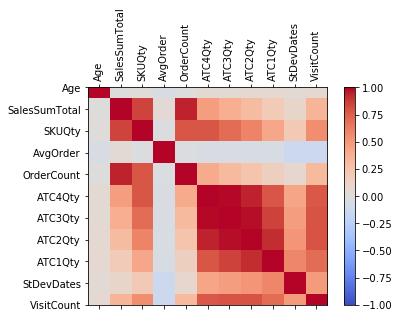

In [12]:
corr = drug_clients_clean.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(drug_clients_clean.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(drug_clients.columns)
ax.set_yticklabels(drug_clients.columns)
plt.show()

* OrderCount is highly correlated with Sales, we may drop for clusterization
* AvrOrder might be derivating from VisitCount / SalesSumTotal
* ATC4Qty,ATC3Qty,ATC2Qty - hightly correlated (ATC1Qty less). May be there were not corrected classified (need additional exploration)

### For clustering we might drop them (not ATC1Qty)

In [13]:
drug_clients_clean.drop(['OrderCount', 'AvgOrder', 'ATC4Qty','ATC3Qty', 'ATC2Qty'], axis=1, inplace=True)

### Reduced dataset for clustering

In [14]:
drug_clients_clustering = drug_clients_clean.copy()
drug_clients_clustering.head(2)

,Age,SalesSumTotal,SKUQty,ATC1Qty,StDevDates,VisitCount
0,43,3280129.32,6058.0,15,104.93,270
1,36,2936887.13,5634.0,15,93.18,241


### Scale data

In [15]:
# scale data
scale = StandardScaler()
drug_clients_clustering_scaled = scale.fit_transform(drug_clients_clustering)

## Check #clusters with K Means algoritm

100%|██████████| 9/9 [02:58<00:00, 19.82s/it]


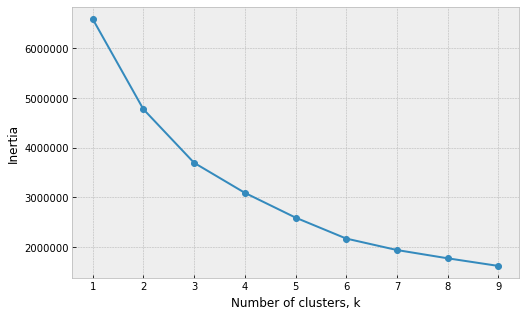

In [16]:
# check for the better value of k
ks = range(1, 10)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k)
    model.fit(drug_clients_clustering_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show();

#### With K Means we observe resonable about 6 clusters.

* We may add this to the DataSet as feature



In [17]:
# Set 6 clusters
final_model = KMeans(n_clusters=6, n_init=50,
    max_iter=500, random_state=11)

# fit model
final_model.fit(drug_clients_clustering_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=6, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=11, tol=0.0001, verbose=0)

In [18]:
# add cluster as feature ot DF
drug_clients_clusters = final_model.predict(drug_clients_clustering_scaled)

# add to initial dataset
drug_clients_clustering['cluster'] = drug_clients_clusters

In [19]:
# See the result
drug_clients_clustering.head(3)

,Age,SalesSumTotal,SKUQty,ATC1Qty,StDevDates,VisitCount,cluster
0,43,3280129.32,6058.0,15,104.93,270,4
1,36,2936887.13,5634.0,15,93.18,241,4
2,21,2446446.42,5387.0,15,104.85,243,4


## Let visualize of Sale distribution for each cluster group

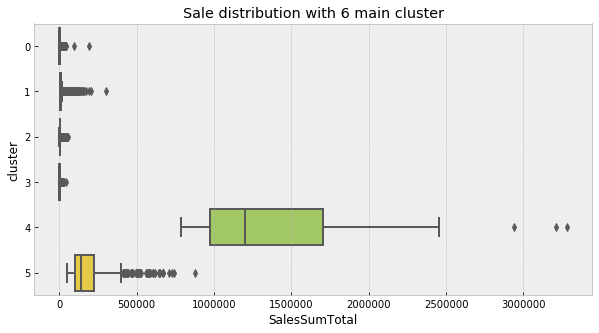

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(x="SalesSumTotal", y="cluster", data=drug_clients_clustering, palette="Set2", orient='h')
plt.title('Sale distribution with 6 main cluster')
plt.show();

### Some inference
* we need to treat 5th and 6th clusters differently since sales are so distinctive from other clusters.
* It might be the wholesale buyers (legal entities), clearly it is two groups of them

### Here another way to present the same idea.

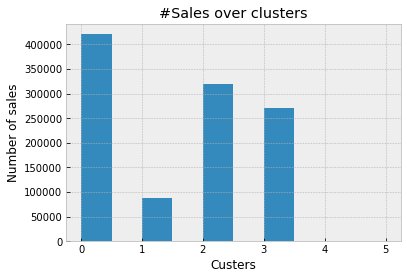

In [21]:
drug_clients_clustering.cluster.hist()
plt.title('#Sales over clusters')
plt.xlabel('Custers')
plt.ylabel('Number of sales')
plt.show();

## Let us divide whole data on two part - customers who buys less than 51K and customers who by more than 52K

Why 52K? We can find low threshhold on 6th cluster

In [22]:
# find low threshhold of 6th cluster to spit the dataset
min(drug_clients_clustering[drug_clients_clustering['cluster'] == 5]['SalesSumTotal'])

51878.68

In [23]:
drug_clients_clustering_group_1 = drug_clients_clustering[drug_clients_clustering['SalesSumTotal'] <= 52000]
drug_clients_clustering_group_2 = drug_clients_clustering[drug_clients_clustering['SalesSumTotal'] >= 52000]

display(f'There is {len(drug_clients_clustering_group_1)} records in group 1 and {len(drug_clients_clustering_group_2)} records in group 2')

'There is 1098229 records in group 1 and 1062 records in group 2'

## We will repead the same approach as before, for the first group (1 mil sales)

100%|██████████| 9/9 [03:58<00:00, 26.45s/it]


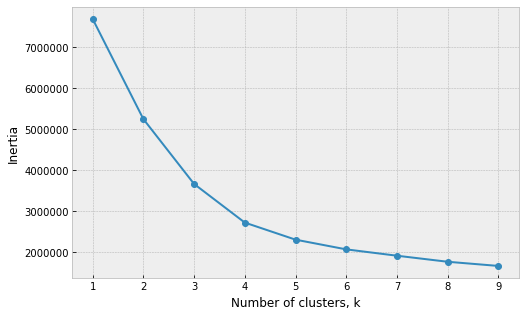

In [24]:
# scale data for the 2 group
drug_clients_clustering_scaled_1 = scale.fit_transform(drug_clients_clustering_group_1)

# check for the better value of k
ks = range(1, 10)
inertias = []

for k in tqdm(ks):
    model = KMeans(n_clusters=k)
    model.fit(drug_clients_clustering_scaled_1)
    inertias.append(model.inertia_)
    
# draw
plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show();

## Here is 4 clusters (for gorup 1)

In [25]:
# Set 6 clusters
final_model = KMeans(n_clusters=4, n_init=50,
    max_iter=500, random_state=11)

# fit model
final_model.fit(drug_clients_clustering_scaled_1)

# add cluster as feature ot DF
drug_clients_clusters_1 = final_model.predict(drug_clients_clustering_scaled_1)

In [84]:
# add to initial dataset
drug_clients_clustering_group_1['cluster'] = drug_clients_clusters_1

# See the result
drug_clients_clustering_group_1.head(3)

,Age,SalesSumTotal,SKUQty,ATC1Qty,StDevDates,VisitCount,cluster
568,22,47920.21,677.0,15,23.54,32,1
592,54,49449.27,661.0,15,98.63,38,1
611,54,47366.63,648.0,15,105.92,78,1


# Cluster discription for customers who buy less than 51K

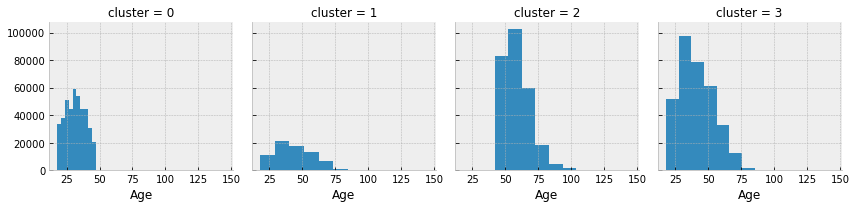

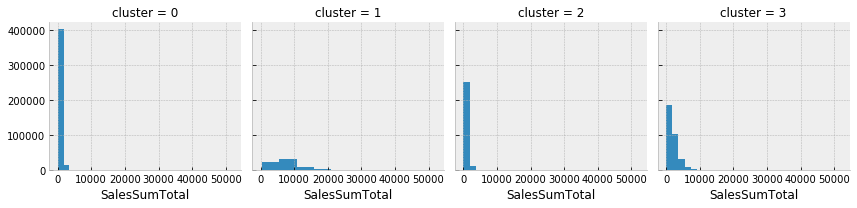

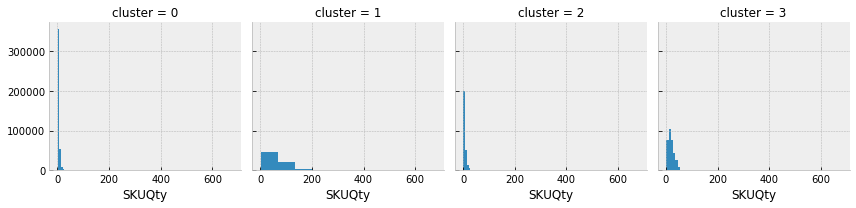

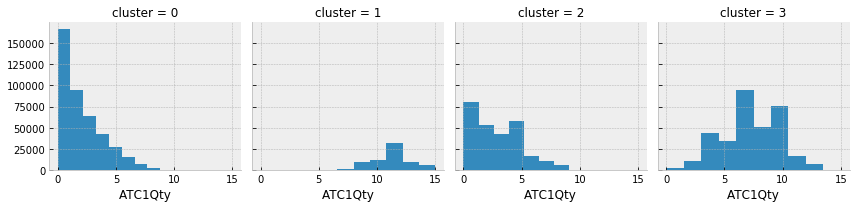

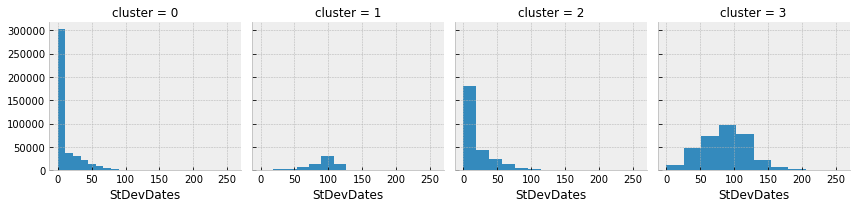

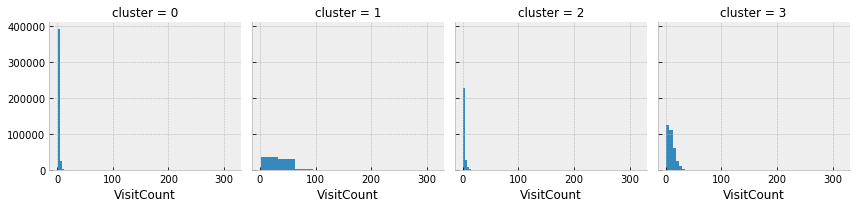

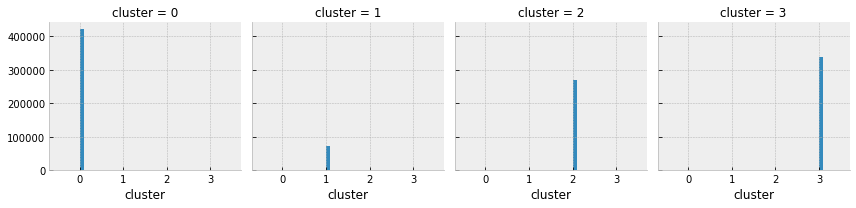

In [27]:
for c in drug_clients_clustering_group_1:
    grid = sns.FacetGrid(drug_clients_clustering_group_1, col='cluster')
    grid.map(plt.hist, c)

**briefly about each cluster**

* Cluster 1 - age widly distr, not high purchases, high amount of SKU, large part of purchases from the ATC1Qty group, not a high density of purchases, high visits

* Cluster 2 - ages more concentated over mean with 50 years as highest level, high purchases, a less assortment, less purchases from the ATC1Qty group, less density of purchases and less visits.

* Cluster 3 - group 45 years old, high drug costs, a narrow list of products, slightly less ATC1Qty purchases than cluster 2, less density of purchases and rarely goes

* Cluster 4 all ages, low expenses, a little more assortment, more purchases from ATC1Qty, high density of purchases, private visits (looking for something)

# How our clusters is looks like for group #1

<Figure size 720x720 with 0 Axes>

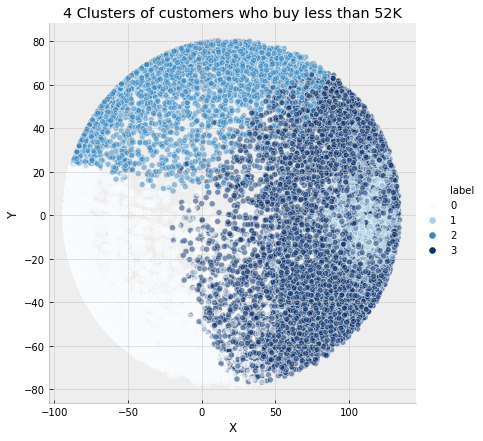

In [86]:
sampled_scaled_to_plot = drug_clients_clustering_group_1.sample(25_000) # 25 k is ok
labels = sampled_scaled_to_plot.cluster
sampled_scaled_to_plot.drop('cluster', axis=1, inplace=True)

# temp table
temp_1 = scale.fit_transform(sampled_scaled_to_plot.astype('uint32'))

# reduce dim and find COS distance
distance = 1 - cosine_similarity(temp_1)
# PCA
pca_2 = PCA(2)
pca_transformed = pca_2.fit_transform(distance)
# Plot
df_to_plot = pd.DataFrame({'X':pca_transformed[:,0], 'Y': pca_transformed[:,1], 'label': labels})
# Draw
plt.figure(figsize=(10,10))
sns.relplot('X', 'Y', data=df_to_plot, hue='label', legend='full', palette="Blues", alpha=.5, height=6)
plt.title('4 Clusters of customers who buy less than 52K')
plt.show();

### Here we can observe the high overlay of the clustres - We might need to use more sophisticated algorithms (or even get more customers features) more clearly separate potential clusters

## Explore sale distribution for Group 1

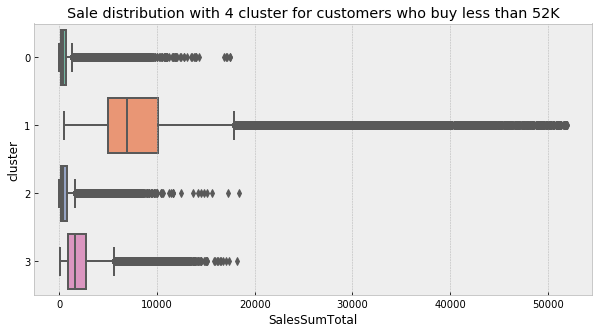

In [29]:
plt.figure(figsize=(10,5))
sns.boxplot(x="SalesSumTotal", y="cluster", data=drug_clients_clustering_group_1, palette="Set2", orient='h')
plt.title('Sale distribution with 4 cluster for customers who buy less than 52K')
plt.show();

### One of the inside about this group is that some customers (especially 1 clusters) often buy significantly more than the average value of the check.

### **For this category, you can use separate marketing offers.**



## Follow up study

- use of other clustering methods (HDBSCAN / TSNE)
- optain more customer data for correct clustering
- deeper study of group 2 (wholesalers)
- inclusion business metrics (profitability, items turnover) in the model and analysis
- more clear clarification of drug groups

--------------------------------------------------------------------------------------------------------------------

# Let us predict for group 1, which cluster customer goes to 

In [102]:
# Data we will work with
data_group1 = drug_clients_clustering_group_1.copy()

# check number of records for each cluster
data_group1.cluster.value_counts()

0    420577
3    337568
2    268775
1     71309
Name: cluster, dtype: int64

### Prepare data with PCA and scale

In [103]:
# Select only 1 cluster

y = data_group1.cluster

data_group1.drop('cluster', axis=1, inplace=True)

In [104]:
data_group1_cluster_1_scaled = StandardScaler().fit_transform(data_group1)

data_group1_cluster_1_scaled_pca = PCA().fit_transform(data_group1_cluster_1_scaled)

### Train / test 

In [106]:
X_train, X_test, y_train, y_test = train_test_split(data_group1_cluster_1_scaled_pca, y, random_state=11, test_size=0.2)

### Let use staking method without grid search

In [107]:
# all proc
n_jobs = -1
random_state = 11 

### Models 

pipe_rf = RandomForestClassifier(random_state=random_state, n_jobs=n_jobs)

pipe_gbc = GradientBoostingClassifier(random_state=random_state)

pipe_ext = ExtraTreesClassifier(random_state=random_state, n_jobs=n_jobs)

pipe_cat = catboost.CatBoostClassifier(random_state=random_state, verbose=False)

pipe_bag = BaggingClassifier(n_jobs=n_jobs, random_state=random_state)

pipe_xgb = xgboost.XGBRFClassifier(n_jobs=n_jobs, random_state=random_state)

### Models ready
look_for = [pipe_rf, pipe_gbc, pipe_ext, pipe_cat, pipe_bag, pipe_xgb]

### Models names
model_dict = { 0:'RandomForestClassifier', 1: "GradientBoostingClassifier", 2:'ExtraTreesClassifier', 3: 'CatBoostClassifier', \
              4:'BaggingClassifier', 5:'xgboost'}

### Use function to iretare over all models

In [126]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
models = []
meta_test = []
meta_train = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        
        meta_test.append(model.predict(X_test))
        meta_train.append(model.predict(X_train))
    
        print('---------------------------------------------')
        print(' accuracy rate is {}'.format(model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model)
        result_acc[index] = model.score(X_test, y_test)


+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForestClassifier
---------------------------------------------
 accuracy rate is 0.9946186135873177
It lasted for 52.249 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is GradientBoostingClassifier
---------------------------------------------
 accuracy rate is 0.9914498784407638
It lasted for 836.99 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is ExtraTreesClassifier
---------------------------------------------
 accuracy rate is 0.9950010471394881
It lasted for 28.595 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is CatBoostClassifier
---------------------------------------------
 accuracy rate is 0.995014705480637
It lasted for 134.679 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model +++++++++++++

## Most of the models show more than 95% accouracy. 
### We might use staking prevent overfitting

In [130]:
print('Model accuracy performace {}'.format(result_acc))

Model accuracy performace {0: 0.9946186135873177, 1: 0.9914498784407638, 2: 0.9950010471394881, 3: 0.995014705480637, 4: 0.9935760268796153, 5: 0.9427078116605812}


### Classification results 

In [120]:
# all model results 
data_results_staked_train = pd.DataFrame(np.hstack((
    
            (meta_test[0]).reshape(-1,1), 
            (meta_test[1]).reshape(-1,1),
            (meta_test[2]).reshape(-1,1),
            (meta_test[3]).reshape(-1,1),
            (meta_test[4]).reshape(-1,1),
            (meta_test[5]).reshape(-1,1)
    
           )),
            columns=[i for i in model_dict.values()])

# set target
data_results_staked_train['target'] = y_test.values

# head
data_results_staked_train.head(8)

,RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,CatBoostClassifier,BaggingClassifier,xgboost,target
0,3.0,3.0,3.0,3.0,3.0,3.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.0,2.0,2.0,2.0,2.0,2.0,2
3,2.0,2.0,2.0,2.0,2.0,2.0,2
4,3.0,3.0,3.0,3.0,3.0,3.0,3
5,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0
7,2.0,2.0,2.0,2.0,2.0,2.0,2


### Using the data - you can accurately predict (95%) customer membership in a particular cluster